In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
rw_len = 16
batch_size = 128

In [7]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [8]:
walker.walk().__next__()

array([[1275, 1262, 1275, ..., 1675, 1676, 1370],
       [ 774, 1112,  557, ..., 2734, 2742, 2667],
       [ 437,  334,  437, ..., 2384, 2387, 2384],
       ..., 
       [ 965,  693,  742, ..., 1749, 2120, 2122],
       [ 285,  234,  285, ...,  278,  464, 2154],
       [ 578,  539, 1749, ...,   47,   63,   84]])

#### Create our NetGAN model

In [9]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=None, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

#### Define the stopping criterion

In [10]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [12]:
eval_every = 10
plot_every = 10

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_4.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****
1      /50       training iterations, took 4 seconds so far...
2      /50       training iterations, took 7 seconds so far...
3      /50       training iterations, took 10 seconds so far...
4      /50       training iterations, took 13 seconds so far...
5      /50       training iterations, took 17 seconds so far...
6      /50       training iterations, took 19 seconds so far...
7      /50       training iterations, took 22 seconds so far...
8      /50       training iterations, took 24 seconds so far...
9      /50       training iterations, took 27 seconds so far...


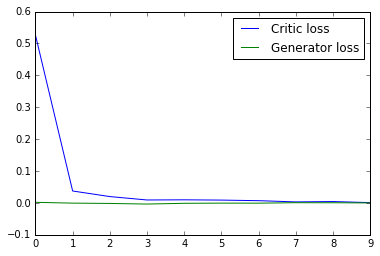

10     /50       training iterations, took 30 seconds so far...


In [ ]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=50)

In [ ]:
log_dict.keys()

In [ ]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [ ]:
sample_many = netgan.generate_discrete(10000, reuse=True)

In [ ]:
samples = []

In [ ]:
for _ in range(6000):
    if (_+1) % 500 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

#### Assemble score matrix from the random walks

In [ ]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [ ]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [ ]:
roc_auc_score(test_labels, test_scores)

In [ ]:
average_precision_score(test_labels, test_scores)